# Explore results after scraping results website

### User variables


In [1]:
Date = '2019-04' # yyyy-mm

### Modules and functions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image

### Load results

Load auction results and data from rdw.

In [3]:
file_name = '../data/drz-data-{}.pkl'.format(Date)
print(file_name)
drz = pd.read_pickle(file_name)
file_name = '../data/rdw-data-{}.pkl'.format(Date)
print(file_name)
rdw = pd.read_pickle(file_name)

../data/drz-data-2019-04.pkl
../data/rdw-data-2019-04.pkl


# Cheap cars with valid inspection

In [4]:
is_cheap = (
    drz.LotType == "Personenauto"
) & (
    drz.Price<3000
) & (
    drz.Price>0
) & ~(
    (
        drz.APKdate.isnull()
    ) | (
        drz.APKdate.apply(lambda x:x == '')
    )
)

drz.loc[is_cheap,
        ["Price","ItemType","ItemBrand","Mfdate","APKdate","OdoKM"]]

,Price,ItemType,ItemBrand,Mfdate,APKdate,OdoKM
2019-4-2010,2480.0,mini cooper s,MINI,16.04.2003,29.06.2019,211.298
2019-4-7102,1989.0,audi a3,AUDI,26.07.2006,28.08.2019,350.178
2019-4-7103,1455.0,toyota aygo,TOYOTA,12.01.2009,13.04.2019,onbekend
2019-4-7104,444.0,fiesta; fiesta 1.25i 51kw st3,FORD,29.08.2003,11.07.2019,227.210
2019-4-7105,444.0,audi a6; 121 kw aut,AUDI,11.03.1999,24.08.2019,348.382
2019-4-7110,1079.0,fiat seicento; 1100,FIAT,21.08.2006,27.07.2019,113.632
2019-4-7111,391.0,polo; sdi 47 kw,VOLKSWAGEN,15.03.2004,10.07.2019,357.147
2019-4-7113,600.0,nissan almera; 1.8 5hb,NISSAN,24.08.2000,20.06.2019,185.301
2019-4-7114,1000.0,1er reihe; 116i,BMW,02.10.2004,19.11.2019,320.173
2019-4-7120,2565.0,c1,CITROËN,05.03.2012,05.07.2019,108.602


In [5]:
rdw.loc[is_cheap,["rdwinfo"]]

,rdwinfo
2019-4-2010,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7102,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7103,"{'aantal_cilinders': {0: 3}, 'aantal_deuren': ..."
2019-4-7104,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7105,"{'aantal_cilinders': {0: 6}, 'aantal_deuren': ..."
2019-4-7110,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7111,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7113,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7114,"{'aantal_cilinders': {0: 4}, 'aantal_deuren': ..."
2019-4-7120,"{'aantal_cilinders': {0: 3}, 'aantal_deuren': ..."


In [6]:
rdw.loc[is_cheap,"rdwinfo"][0]

{'aantal_cilinders': {0: 4},
 'aantal_deuren': {0: 2},
 'aantal_wielen': {0: 4},
 'aantal_zitplaatsen': {0: 4},
 'api_gekentekende_voertuigen_assen': {0: 'https://opendata.rdw.nl/resource/3huj-srit.json'},
 'api_gekentekende_voertuigen_brandstof': {0: 'https://opendata.rdw.nl/resource/8ys7-d773.json'},
 'api_gekentekende_voertuigen_carrosserie': {0: 'https://opendata.rdw.nl/resource/vezc-m2t6.json'},
 'api_gekentekende_voertuigen_carrosserie_specifiek': {0: 'https://opendata.rdw.nl/resource/jhie-znh9.json'},
 'api_gekentekende_voertuigen_voertuigklasse': {0: 'https://opendata.rdw.nl/resource/kmfi-hrps.json'},
 'bruto_bpm': {0: 6598},
 'cilinderinhoud': {0: 1598},
 'datum_eerste_afgifte_nederland': {0: 20150109},
 'datum_eerste_toelating': {0: 20030416},
 'datum_tenaamstelling': {0: 20190213},
 'eerste_kleur': {0: 'GRIJS'},
 'europese_voertuigcategorie': {0: 'M1'},
 'export_indicator': {0: 'Nee'},
 'handelsbenaming': {0: 'MINI COOPER S'},
 'inrichting': {0: 'hatchback'},
 'kenteken': {0

In [7]:
pd.DataFrame(rdw.loc[is_cheap,"rdwinfo"][0]).T

,0,1
aantal_cilinders,4,NaN
aantal_deuren,2,NaN
aantal_wielen,4,NaN
aantal_zitplaatsen,4,NaN
api_gekentekende_voertuigen_assen,https://opendata.rdw.nl/resource/3huj-srit.json,NaN
api_gekentekende_voertuigen_brandstof,https://opendata.rdw.nl/resource/8ys7-d773.json,NaN
api_gekentekende_voertuigen_carrosserie,https://opendata.rdw.nl/resource/vezc-m2t6.json,NaN
api_gekentekende_voertuigen_carrosserie_specifiek,https://opendata.rdw.nl/resource/jhie-znh9.json,NaN
api_gekentekende_voertuigen_voertuigklasse,https://opendata.rdw.nl/resource/kmfi-hrps.json,NaN
bruto_bpm,6598,NaN


# Pictures of lots

In [8]:
# ix=drz.N_images.idxmax()
ix=drz.Price.idxmax(); print('Price: EUR {:g}\n\n'.format(drz.loc[ix,'Price']))
# Mfdate = drz.Mfdate.apply(lambda x: pd.to_datetime(x,format='%d.%m.%Y') if len(x)==10 else pd.np.NaN)
# ix=Mfdate.idxmin(); print('year of mf: {:s}\n\n'.format(drz.loc[ix,'Mfdate']))
# ix = '2019-2-2005' # largest km/day
# ix = '2019-2-7345' # largest km

print(ix)
for u in drz.loc[ix,'Images']:
    print(u)
    print(drz.loc[ix,'Source'])
    display(Image(url=u,width=400))
    

Price: EUR 102666


2019-4-2411
http://www.domeinenrz.nl/ufc/static/1553606663/thumb/domeinenrz_sites/7368b730567b9799949475b387fc5d0a/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0004_april?=&veilingen=2019-0004&meerfotos=K1900042411


http://www.domeinenrz.nl/ufc/static/1553606669/thumb/domeinenrz_sites/e8dafc559e0462180162e1275402a87e/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0004_april?=&veilingen=2019-0004&meerfotos=K1900042411


http://www.domeinenrz.nl/ufc/static/1553606668/thumb/domeinenrz_sites/d1ccef423b2c5cc6dc639929868b1952/1024/768/image.jpg
http://www.domeinenrz.nl/catalogus/verkoop_bij_inschrijving_2019-0004_april?=&veilingen=2019-0004&meerfotos=K1900042411


# Usage

How many km are driven per year or day?

### Odometer conversion

In [9]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    df.OdoKM = df.OdoKM.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace('onbekend','nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

In [10]:
odo_str2float(drz)

drz[['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']]

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2019-4-1800,3.104800e+04,31.048,31048.0,nan,NaN
2019-4-1801,1.771600e+04,17.716,17716.0,nan,NaN
2019-4-1802,5.993000e+03,5.993,5993.0,nan,NaN
2019-4-1803,1.816700e+04,18.167,18167.0,nan,NaN
2019-4-1804,1.059000e+03,1.059,1059.0,nan,NaN
2019-4-1805,1.119600e+04,11.196,11196.0,nan,NaN
2019-4-1807,1.034000e+03,1.034,1034.0,nan,NaN
2019-4-1808,7.942000e+03,7.942,7942.0,nan,NaN
2019-4-1810,6.658000e+03,6.658,6658.0,nan,NaN
2019-4-1811,1.441800e+04,14.418,14418.0,nan,NaN


### Dates

In [11]:
AuctDate = pd.to_datetime(drz.index[0][0:-5], format = '%Y-%m')

# serial date
drz["Mfdate_ser"] = drz.Mfdate.apply(lambda x:pd.to_datetime(x, format = '%d.%m.%Y') if x!='' else pd.np.NaN)

# age
drz["Age"] = (AuctDate - drz.Mfdate_ser)
drz["Age_year"] = drz.Age.apply(lambda x:x.days/365.25)

- - - -
# Continue with cars only

In [12]:
out = drz.Price.copy()
Features = drz.loc[:,["ItemBrand","ItemType","Odo","Age_year"]].copy()

In [13]:
# Drop rows
Subsel = drz.LotType == 'Personenauto'
dropIx=drz[~Subsel].index
out.drop(index=dropIx,inplace=True)
Features.drop(index=dropIx,inplace=True)

### one hot encoding brand and model

In [14]:
Dummies = pd.get_dummies(Features.ItemBrand,prefix='Brand_',drop_first=False)
Features = pd.concat([Features,Dummies],axis=1)

Features.describe()

,Odo,Age_year,Brand__AUDI,Brand__BMW,Brand__CHEVROLET,Brand__CITROËN,Brand__DAEWOO,Brand__FIAT,Brand__FORD,Brand__HYUNDAI,...,Brand__QUATTRO,Brand__RENAULT,Brand__ROVER,Brand__SAAB,Brand__SEAT,Brand__SKODA,Brand__SUZUKI,Brand__TOYOTA,Brand__VOLKSWAGEN,Brand__VOLVO
count,163.000000,166.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,193461.699669,11.754995,0.082353,0.111765,0.005882,0.047059,0.005882,0.047059,0.047059,0.011765,...,0.005882,0.035294,0.011765,0.005882,0.035294,0.023529,0.017647,0.011765,0.217647,0.041176
std,91688.166131,6.419322,0.275714,0.316008,0.076696,0.212390,0.076696,0.212390,0.212390,0.108144,...,0.076696,0.185067,0.108144,0.076696,0.185067,0.152025,0.132054,0.108144,0.413865,0.199285
min,13.000000,0.919918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,128889.500000,7.616016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,192614.000000,11.392197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,250157.000000,15.028747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,398248.000000,54.173854,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Plotting

In [15]:
def ecdf(data):
    x = sorted(data)
    y = pd.np.arange(0,len(x))/len(x)
    return x,y

# # example
# x,y = ecdf(km_p_day)
# plt.plot(x,y)

In [16]:
# km per day
km_p_day = Features.Odo/(Features.Age_year*365.25).fillna(0)
sel = ~(km_p_day.isna() | (km_p_day == pd.np.inf))
km_p_day = km_p_day.loc[sel]

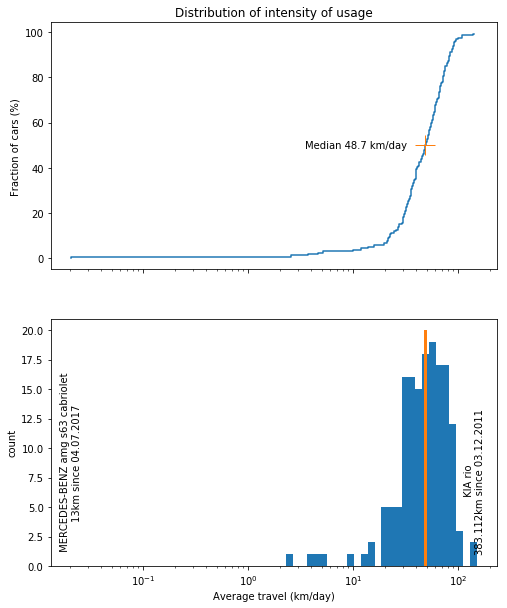

In [17]:
# Plot ecdf and hist
x,y = ecdf(km_p_day)
fig,axs = plt.subplots(ncols=1,nrows=2, figsize=[8,10],sharex=True)

# ecdf
ax = axs[0]
ax.step(x,y*100)
ax.plot(pd.np.median(x),50,'+',markersize=20)
ax.text(pd.np.median(x),50,'Median {:.1f} km/day      '.format(pd.np.median(x)),ha='right',va='center');
ax.set_title('Distribution of intensity of usage')
ax.set_ylabel('Fraction of cars (%)')

xl = axs[0].get_xlim()

# hist
ax = axs[1]
ax.hist(x,bins=pd.np.logspace(-1,pd.np.log10(xl[1]),50))
yl = axs[1].get_ylim()
ax.plot(pd.np.array([1,1])*pd.np.median(x),yl,'-',linewidth=3)
ax.set_xlabel('Average travel (km/day)')
ax.set_ylabel('count')

ax.text(
    km_p_day.min(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmin(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.text(
    km_p_day.max(),1,
    ' {} {}\n{}km since {}'.format(*rdw.loc[km_p_day.idxmax(),['ItemBrand','ItemType','OdoKM','Mfdate']].values),
    rotation=90,
    va='bottom',
    ha='center'
)

ax.set_xscale('log')


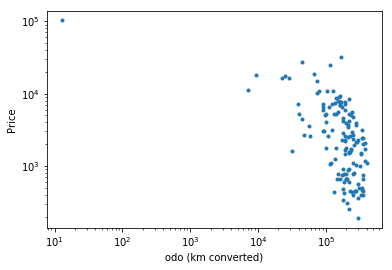

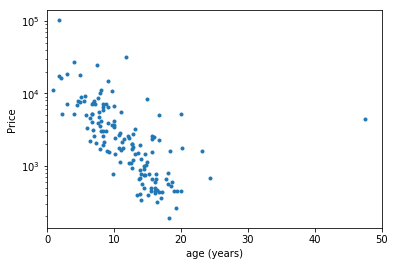

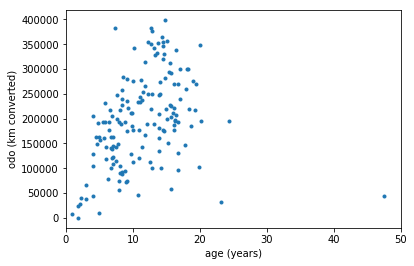

In [18]:
plt.plot(Features.Odo,out,'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('odo (km converted)')
plt.ylabel('Price')

plt.figure()
plt.plot(Features.Age_year,out,'.')
plt.yscale('log')
plt.xlabel('age (years)')
plt.ylabel('Price')
plt.xlim(0,50)


plt.figure()
plt.plot(Features.Age_year,Features.Odo,'.')
plt.xlabel('age (years)')
plt.ylabel('odo (km converted)')
plt.xlim(0,50)

plt.show()



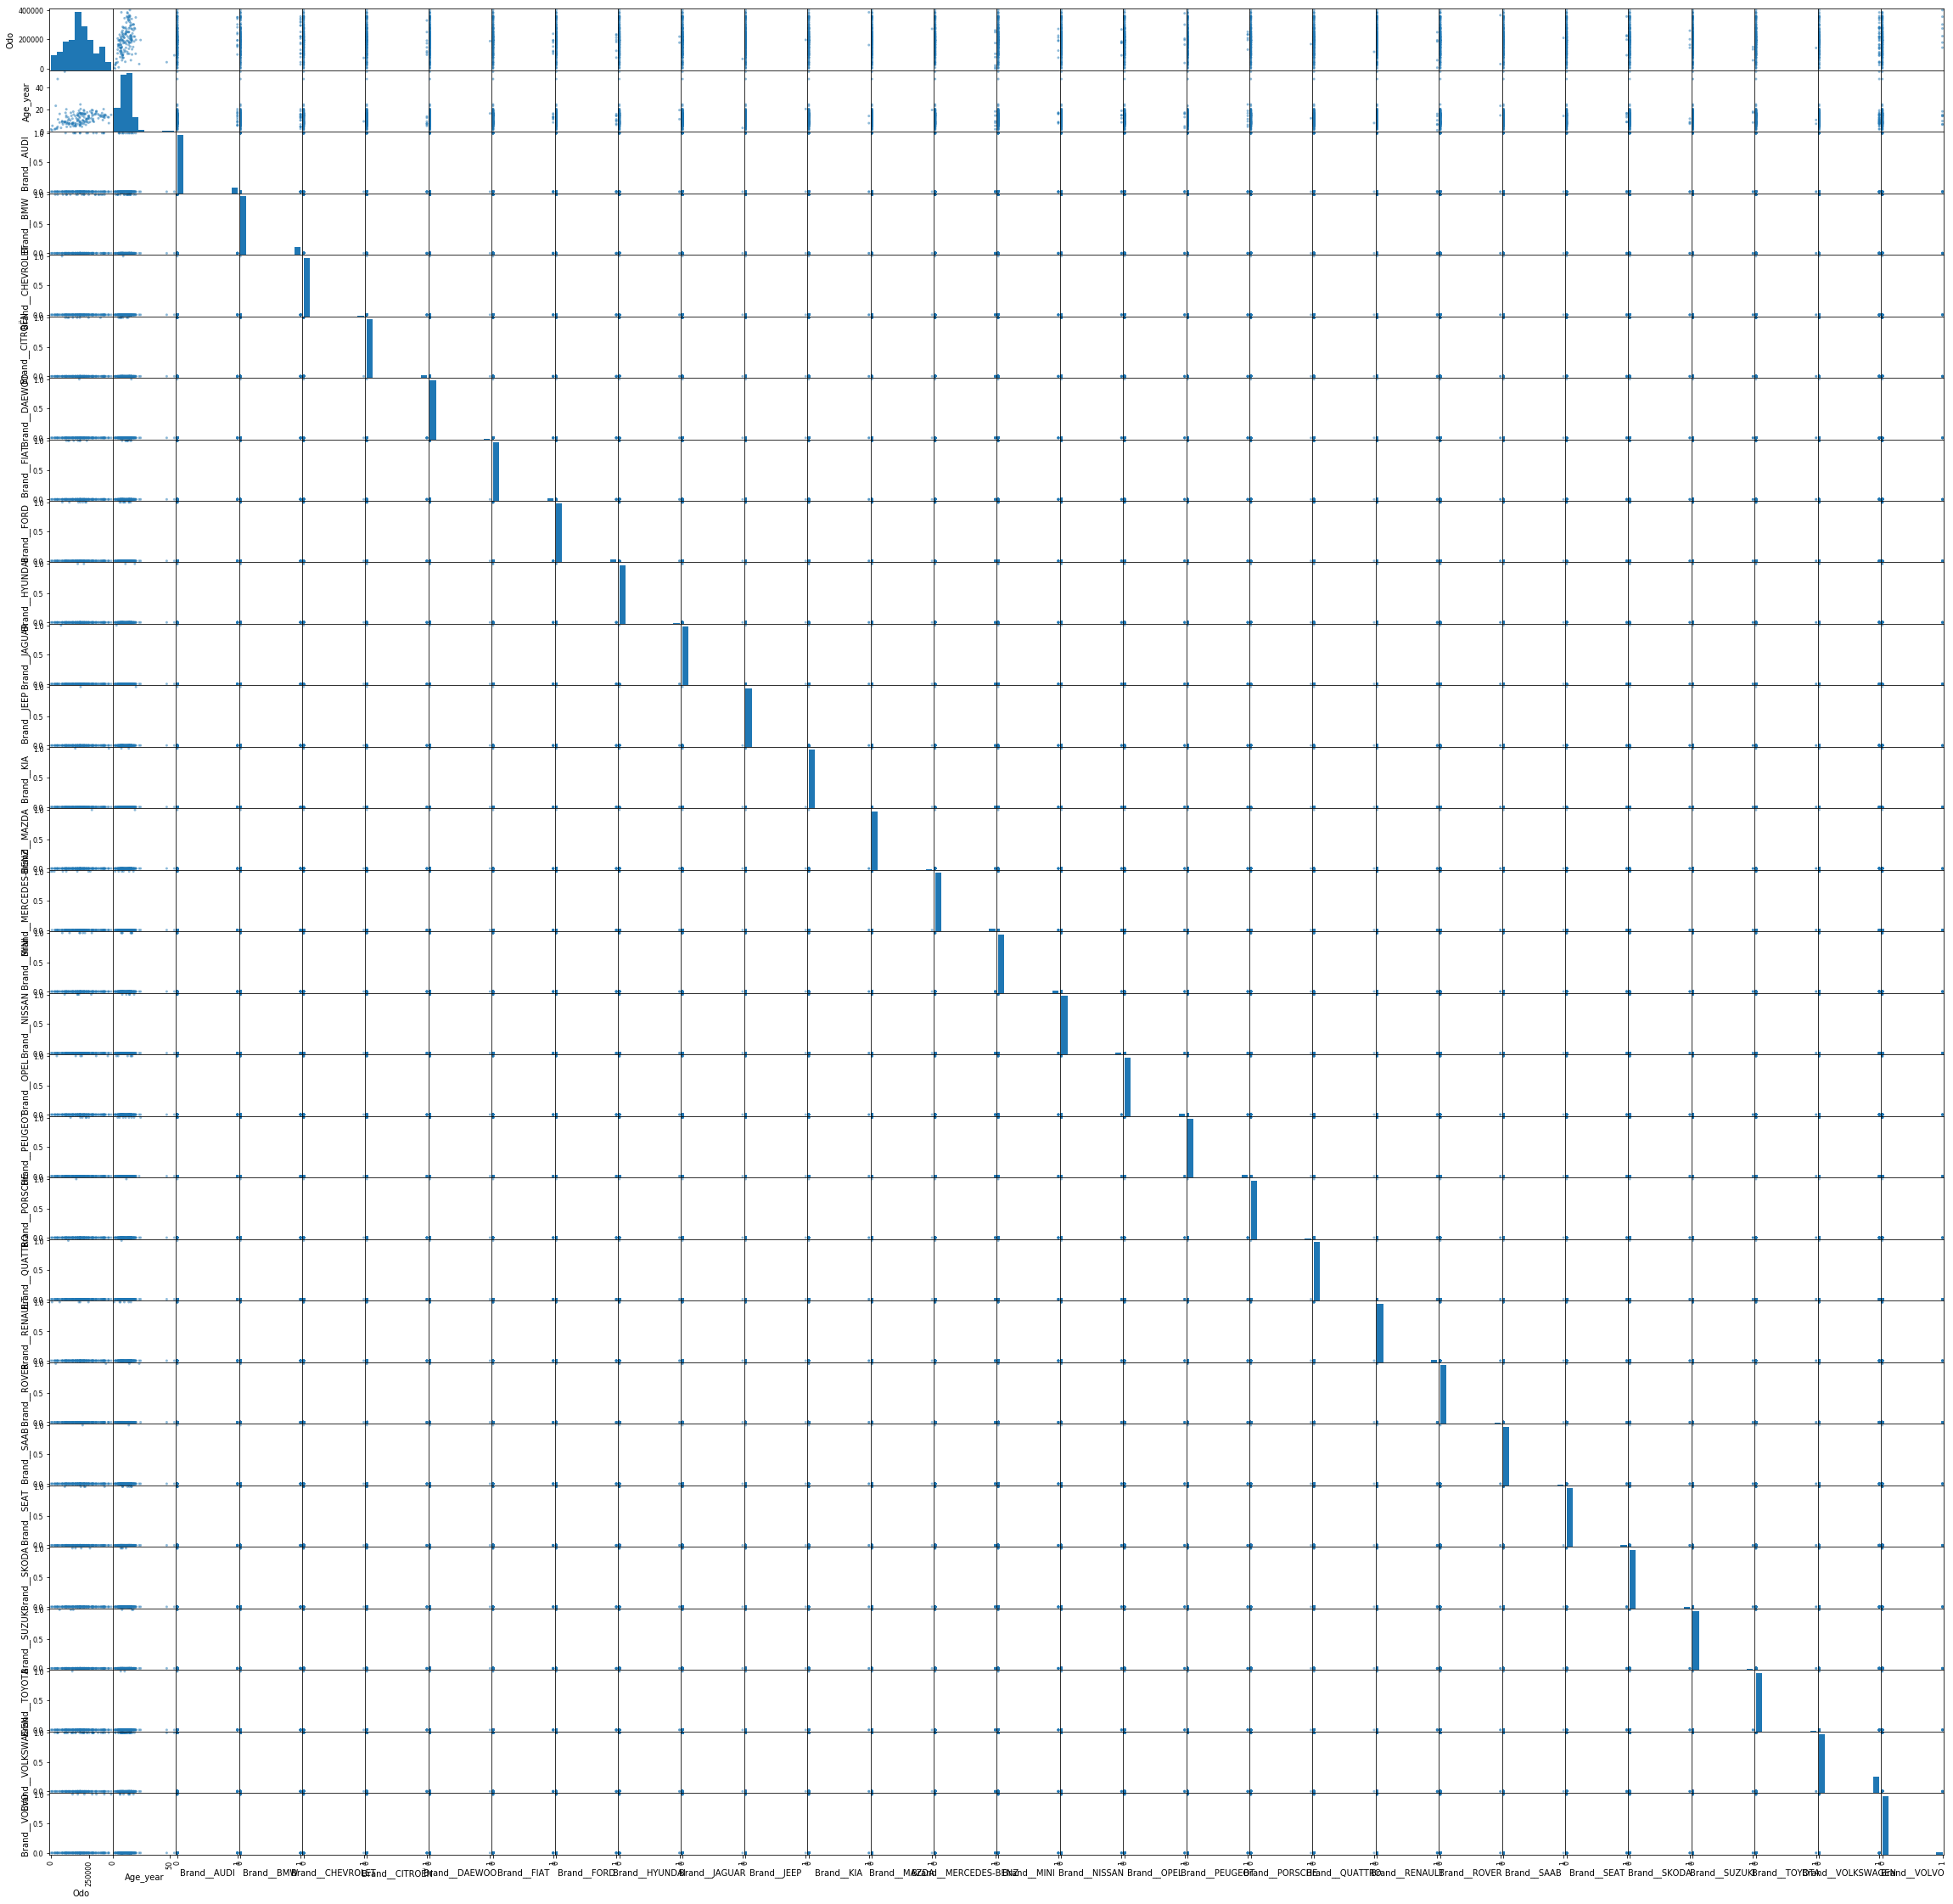

In [19]:
pd.plotting.scatter_matrix(Features,figsize=[40,40])
plt.show()